In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('seaborn-white')
plt.viridis()
mpl.rc('savefig',bbox='tight',dpi=96)
mpl.rc('xtick',labelsize=20)
mpl.rc('ytick',labelsize=20)
mpl.rc('axes',labelsize=25)
mpl.rc('axes',titlesize=25)
mpl.rc('axes',titlepad=15)
mpl.rc('font',family='serif')
mpl.rc('legend',fontsize=20)
mpl.rc('mathtext',default='regular',fontset='dejavuserif')
%matplotlib inline

import tensorflow as tf

In [2]:
%load_ext autoreload
%autoreload 2

In [73]:
# slices for future plotting
size = 64
s0, s1, s2 = int(0.25*size), int(0.5*size), int(0.75*size)
ss = [np.s_[s1,:,:],np.s_[:,s1,:],np.s_[:,:,s1]]

In [74]:
# True structure
target = np.load("l1_target.npy")

target_trimmed = target.copy()
target_trimmed[np.abs(target) < 0.1 * np.abs(target)] = 0.0
target_trimmed /= np.max(np.abs(target_trimmed))

# Forward model

In [75]:
# Generating the diffraction data
target_diffs = np.abs(np.fft.fftn(target_trimmed, norm='ortho'))

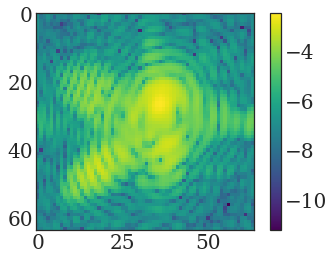

In [76]:
# load the diffraction patterns 
plt.imshow(np.log(np.fft.fftshift(target_diffs[16])))
plt.colorbar()

# Estimating initial boundaries (support?)

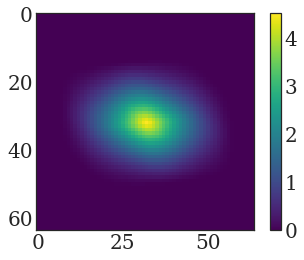

In [77]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.ifftn(target_diffs**2, norm='ortho'))[32]))
plt.colorbar()

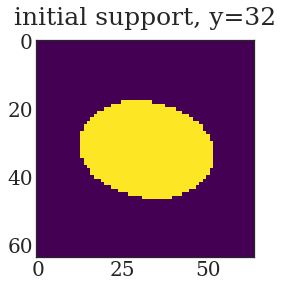

In [78]:
initial_support = np.abs(np.fft.fftshift(np.fft.ifftn(target_diffs**2, norm='ortho'))) > 0.5
plt.imshow(initial_support[32])
plt.title("initial support, y=32")
plt.show()

## Simple Reconstruction: 

In [79]:
def reconstruct(initial_guess,
                initial_support,
                n_iterations, # number of optimization steps for each set of l1 weights 
                outer_iterations, # number of l1 reweighting steps 
                learning_rate=1e1, # initial adam step size
                l1_const=1.0):  # weight to use for the l1 loss at each optimization
    
    guess0 = np.copy(initial_guess)
    
    tf.reset_default_graph()
    with tf.device('/gpu:0'):
        tf_diffs = tf.constant(target_diffs, dtype='float32')
        tf_initial_support = tf.constant(initial_support.astype('complex64'), dtype='complex64')
        
        # Constructing the object variable
        tf_obj_v = tf.Variable(np.concatenate([np.real(guess0), np.imag(guess0)]), dtype='float32')
        tf_obj_reshaped = tf.reshape(tf_obj_v, [2, *guess0.shape])
        tf_obj = tf.complex(tf_obj_reshaped[0], tf_obj_reshaped[1])
        tf_obj = tf_obj * initial_support

        # The l1 weights
        l1_weights = tf.Variable(np.zeros(guess0.shape), dtype='float32')
        # The reweighting operation. Using epsilon = 1e-3
        assign_weights_op = l1_weights.assign(1 / (tf.abs(tf_obj) + 1e-3))
        
        # The forward model
        exitwave = tf.abs(tf.fft3d(tf_obj) / 64.0**1.5)
        loss = tf.reduce_sum((exitwave - tf_diffs)**2)
        
        l1_loss =  tf.reduce_sum(tf.abs(tf_obj) * l1_weights)
        losses_sum = loss + l1_const * l1_loss
        
        # Adam optimizer. Using the placeholder here for some flexibility with the step size
        lr_placeholder = tf.placeholder(tf.float32)
        opt = tf.train.AdamOptimizer(lr_placeholder)
        minimize_op = opt.minimize(losses_sum, var_list=[tf_obj_v])
        
        # To reset the internal minimizer state after each l1 reweighting
        reset_optimizer_op = tf.variables_initializer(opt.variables())

        sess_config = tf.ConfigProto()
        #sess_config.gpu_options.allow_growth = True 
        #sess_config.allow_soft_placement = True
        session = tf.Session(config=sess_config)
        session.run(tf.global_variables_initializer())

        lossvals = []
        lowest = np.inf
    final_structures = []
    final_outer_losses = []
    inner_losses = []
    
    # If I want a decreasing step size. Not actually using that here.
    lr_values = np.logspace(np.log10(learning_rate), np.log10(learning_rate) -0, n_iterations)
    for i in tqdm(range(outer_iterations)):
        
        # Setting the l1 weights
        session.run(assign_weights_op)
        inner_loss = []
        for j in range(n_iterations):    
            l1val, lossval, _ = session.run([l1_loss, loss, minimize_op],
                                            feed_dict={lr_placeholder:lr_values[j]})
            inner_loss.append([l1val, lossval])
            l1_part = l1val * l1_const
            if j % 200 == 0:
                print(f"Outer {i}, inner {j}, l1 {l1val:10.3g}, l1_loss_part {l1_part:10.3g} loss {lossval:10.3g}")
            lowest = np.minimum(lowest, lossval)
        final_outer_losses.append(session.run(loss))
        final_structures.append(session.run(tf_obj))
        inner_losses.append(inner_loss)
        session.run(reset_optimizer_op)
    
    return np.array(final_structures), np.array(final_outer_losses), np.array(inner_losses)

Outer 0, inner 0, l1   2.35e+04, l1_loss_part       11.8 loss   1.29e+04
Outer 0, inner 200, l1   1.43e+04, l1_loss_part       7.16 loss        647
Outer 0, inner 400, l1   1.38e+04, l1_loss_part       6.92 loss       61.4
Outer 0, inner 600, l1   1.36e+04, l1_loss_part       6.81 loss       22.8
Outer 0, inner 800, l1   1.35e+04, l1_loss_part       6.73 loss       16.1
Outer 1, inner 0, l1   2.33e+04, l1_loss_part       11.6 loss       13.1
Outer 1, inner 200, l1   1.85e+04, l1_loss_part       9.27 loss          8
Outer 1, inner 400, l1   1.76e+04, l1_loss_part       8.81 loss       6.25
Outer 1, inner 600, l1    1.7e+04, l1_loss_part       8.49 loss       5.53
Outer 1, inner 800, l1   1.65e+04, l1_loss_part       8.23 loss       5.47
Outer 2, inner 0, l1   2.15e+04, l1_loss_part       10.7 loss       5.44
Outer 2, inner 200, l1   1.62e+04, l1_loss_part       8.11 loss       6.38
Outer 2, inner 400, l1   1.62e+04, l1_loss_part       8.12 loss       6.38
Outer 2, inner 600, l1   1.62e+

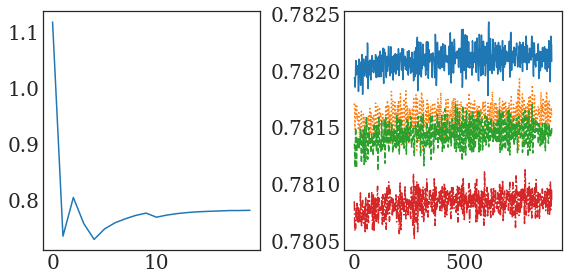

In [85]:
guess_test = (np.random.randn(*target.shape) +  1j * np.random.randn(*target.shape)) / 2
guess_test *= initial_support

# The numbers used here have been optimized via trial and error.
# For the "l1_const", I am trying to ensure that both the l1 loss and the amplitude loss 
# contributions to the total loss are roughly of the same order (with the l1 loss just slightly larger)
# This seems to output the best results.
[
    final_structures, 
    final_outer_losses,
    inner_losses
] = reconstruct(guess_test,
                n_iterations=1000,
                outer_iterations=20,
                learning_rate=5e-3,
                l1_const=5e-4,
                initial_support=initial_support)

fig, axs = plt.subplots(1, 2, figsize=[8,4])
axs[0].plot(np.log10(np.array(final_outer_losses)))

linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
for i in range(4):
    axs[1].plot(np.log10(inner_losses[-(i+1),100:, 1]), ls=linestyles[i])
plt.tight_layout()
plt.show()


#plt.ylabel(r'log$_{10}$(loss)')
#plt.xlabel('iterations')
#plt.savefig('loss.png', bbox_inches='tight')
#plt.show()

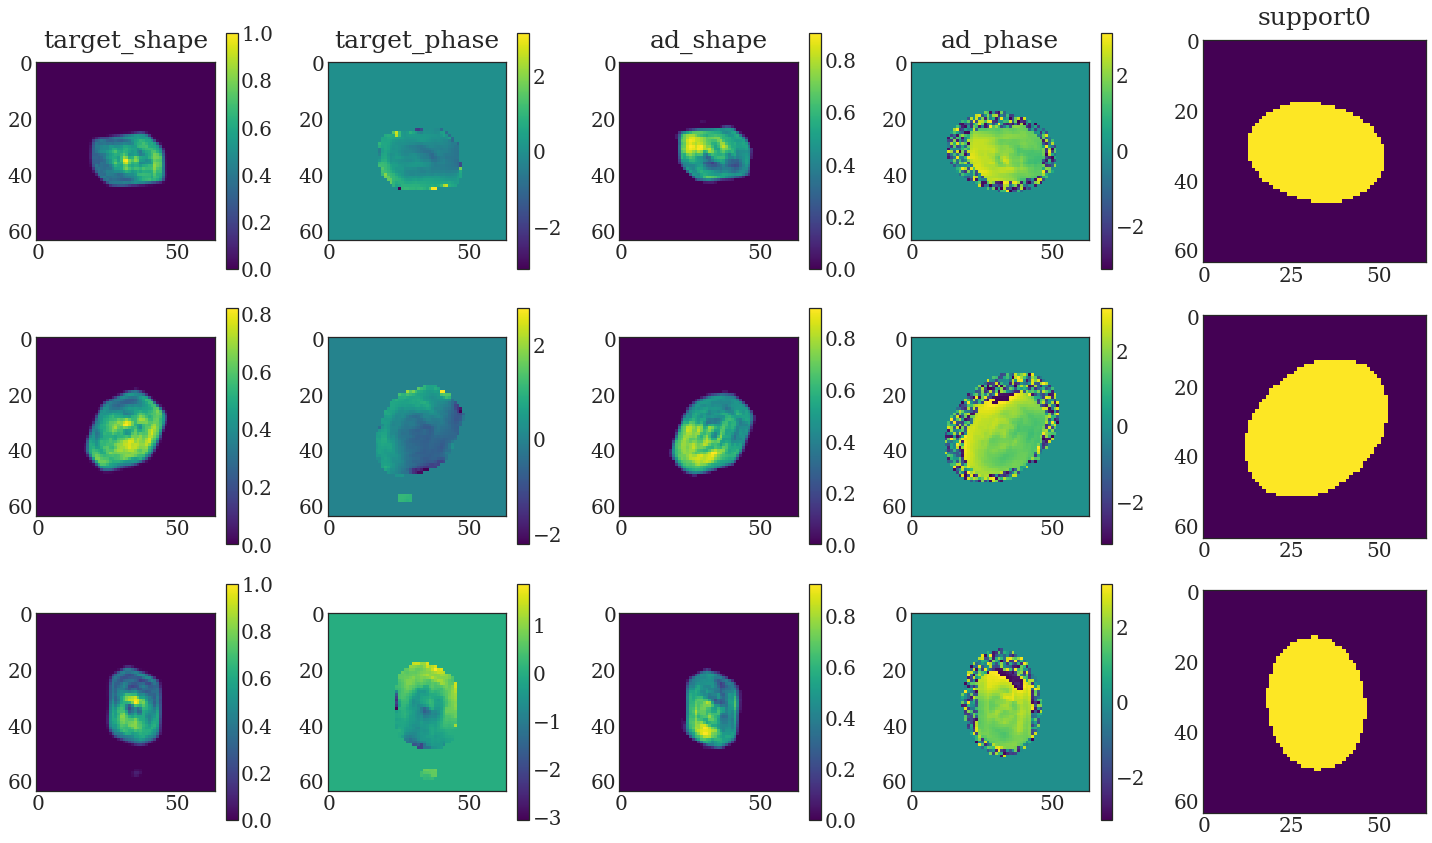

In [86]:
recon = final_structures[-1].copy()
recon /= np.abs(recon).max()
#recon[np.abs(recon) < (0.1 * np.abs(recon).max())] = 0
fig,ax = plt.subplots(3,5, figsize=(20,12))

j=0; ax[0,j].set_title('target_shape')
for i in range(3): 
    img = ax[i,j].imshow(np.abs(target_trimmed)[ss[i]])
    plt.colorbar(img,ax=ax[i,j])

j=1; ax[0,j].set_title('target_phase')
for i in range(3): 
    img = ax[i,j].imshow(np.angle(target_trimmed)[ss[i]])
    plt.colorbar(img,ax=ax[i,j])
    
j=2; ax[0,j].set_title('ad_shape')
for i in range(3): 
    img = ax[i,j].imshow(np.abs(recon[ss[i]]))
    plt.colorbar(img,ax=ax[i,j])
    
j=3; ax[0,j].set_title('ad_phase')
for i in range(3): 
    img = ax[i,j].imshow(np.angle(recon[ss[i]]))
    plt.colorbar(img,ax=ax[i,j])

j=4; ax[0,j].set_title('support0')
for i in range(3): img = ax[i,j].imshow(np.abs(initial_support[ss[i]]))
    
plt.tight_layout()
plt.show()